In [68]:
import pandas as pd
import numpy as np
import math
from scipy.stats import nbinom, gamma

import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [10, 10]

import seaborn as sns

import sys

In [69]:
net = pd.read_csv("../test/va_commute_net.csv",delim_whitespace=True,header=None)
pop = pd.read_csv("../test/va_pop.csv",delim_whitespace=True,header=None)
pop_vec=np.array(pop.iloc[:,1])
net_matrix = net.pivot(index=0,columns=1,values=3)

In [70]:
pop
pop.iloc[:,1]

0       32316
1      109330
2       14860
3       13145
4       31605
        ...  
128     92108
129    449974
130     22630
131     14954
132     28078
Name: 1, Length: 133, dtype: int64

(array([3.336e+03, 5.400e+01, 7.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.700e+01, 4.600e+01, 4.600e+01, 2.400e+01]),
 array([1.00086174e-06, 9.58066134e-02, 1.91612226e-01, 2.87417838e-01,
        3.83223451e-01, 4.79029064e-01, 5.74834676e-01, 6.70640289e-01,
        7.66445901e-01, 8.62251514e-01, 9.58057126e-01]),
 <BarContainer object of 10 artists>)

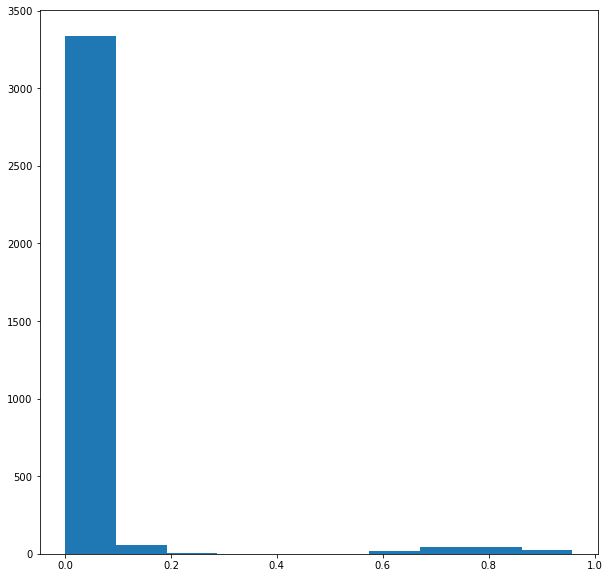

In [71]:
plt.hist(net.iloc[:,3])

In [72]:
net_matrix_rescaled = net_matrix*np.array(pop.iloc[:,1])
net_matrix_rescaled=net_matrix_rescaled.fillna(value=0)

In [73]:
pop.sort_values(by=1,ascending=False)

,0,1
28,51059,1147532
72,51153,470335
129,51810,449974
52,51107,413538
20,51041,352802
...,...,...
103,51595,5346
22,51045,5131
8,51017,4147
119,51720,3981


In [74]:
num_patches = pop.shape[0]


# seeding infections
infection_vector = np.zeros(num_patches)
infection_vector[28]=100
infection_vector[72]=100
infection_vector[129]=100
infection_vector[52]=100
infection_vector[20]=100

disease_matrix = np.zeros((num_patches,3))
disease_matrix[:,0]=pop.iloc[:,1]-infection_vector
disease_matrix[:,1]=infection_vector

# sequence of state matrices
disease_matrix_ts = [disease_matrix]
delta_I_ts = [disease_matrix[:,1]]

In [75]:
# disease parameters
alpha=.97
beta =24.6
recovery = 1 #recover after these number of timesteps?
#birth_rate .017 per year
birth = 0

ITERS = 25

In [76]:
for i in range(0,ITERS):
    last_matrix = disease_matrix_ts[-1]
    S_t, I_t, R_t = last_matrix[:,0], last_matrix[:,1], last_matrix[:,2]
    print("infection vector",I_t)
    
    # get force of infection
    # little i is infective fraction
    i_t = I_t/pop_vec
    infective_force_mat = np.matrix(net_matrix_rescaled*i_t)
    print(infective_force_mat.shape)
    influx = np.array([(np.sum(infective_force_mat[k])-infective_force_mat[k,k]) for k in range(0,num_patches)])
    print(influx)
    
    delta_I_t = np.zeros(num_patches)
    #influx=grav_output["influx"]
    #print(influx)
    iota_t = np.array([gamma.rvs(scale=1,a=i) if i > 0 else 0 for i in influx])
    print(iota_t)
    
    for k in range(0,num_patches):
        if I_t[k] or iota_t[k] > 0: # new infections not getting introduced to other regions???
            lambda_t = (beta*S_t[k]*(I_t[k]+iota_t[k])**(alpha))/pop_vec[k]
            #variance= lambda_t + (1/I_t[k])*(lambda_t**2)
            #p = lambda_t/variance
            n = I_t[k]+iota_t[k] # This allows the infection to spread to other regions. but is this actually correct?
            p = 1/(1+(lambda_t/n))
            
            try:
                delta_I_t[k] = min(S_t[k],nbinom.rvs(n,p))
            except ValueError:
                print("p",p,"n",n,"I_t[k]",I_t[k],variance)
        else:
            delta_I_t[k] = 0
            
    print("change in I",delta_I_t)
    if i >= recovery-1:
        delta_R_t = np.maximum(delta_I_ts[-(recovery)],0) # do recovery step
    else:
        delta_R_t=0
    delta_I_ts.append(delta_I_t)
    
    next_matrix = np.array([
        S_t-delta_I_t+birth,
        I_t+delta_I_t-delta_R_t,
        R_t+delta_R_t
    ]).T
    print(np.sum(next_matrix,axis=0))
    #print(np.sum(next_matrix,axis=1))
    disease_matrix_ts.append(next_matrix)

infection vector [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.
 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 100.   0.   0.   0.]
(133, 133)
[1.25277055e-01 1.39641456e-01 0.00000000e+00 1.00079177e+01
 1.24440020e-01 6.53338560e-02 1.67360523e+01 1.27563137e-01
 0.00000000e+00 2.50553856e-02 1.12431738e-01 2.73656045e-02
 1.04636478e+00 6.96651718e-02 1.40334464e+00 1.09371297e-02
 3.93325808e+00 2.14961307e-02 4.48736155e+00 2.7232

<AxesSubplot:>

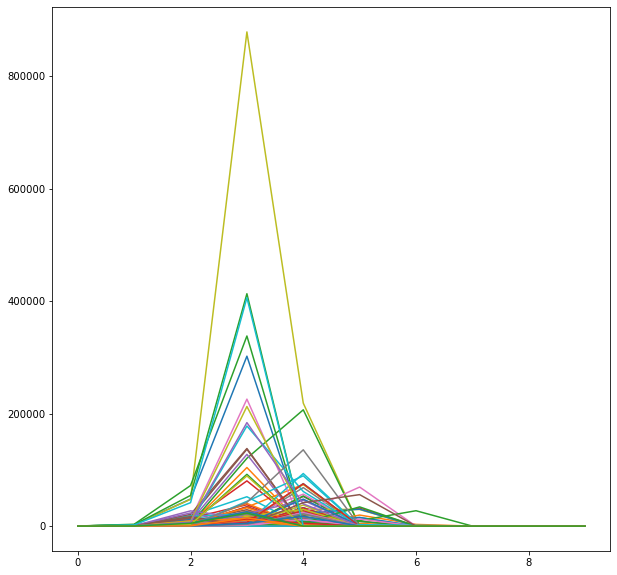

In [77]:
ts_data = pd.DataFrame(np.array([x[:,1] for x in disease_matrix_ts]))
ts_data.iloc[0:10,:].plot(legend=False)